<a href="https://colab.research.google.com/github/dderyashn/Classifying-Road-Symbols/blob/main/Classifying_Road_Symbols.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.


In [4]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Flatten, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random

In [6]:
np.random.seed(0)

In [7]:
#Unpickled file implementation to make pickled files usable
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
  valid_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)

In [8]:
X_train, y_train = train_data['features'], train_data['labels']
X_valid, y_valid = valid_data['features'], valid_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [9]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [10]:
assert(X_train.shape[0] == y_train.shape[0]), 'The number of train images is not equal to the number of labels.'
assert(X_valid.shape[0] == y_valid.shape[0]), 'The number of validation images is not equal to the number of labels.'
assert(X_test.shape[0] == y_test.shape[0]), 'The number of test images is not equal to the number of labels.'

assert(X_train.shape[1:] == (32, 32, 3)), 'The dimensions should be (32, 32, 3)'
assert(X_valid.shape[1:] == (32, 32, 3)), 'The dimensions should be (32, 32, 3)'
assert(X_test.shape[1:] == (32, 32, 3)), 'The dimensions should be (32, 32, 3)'

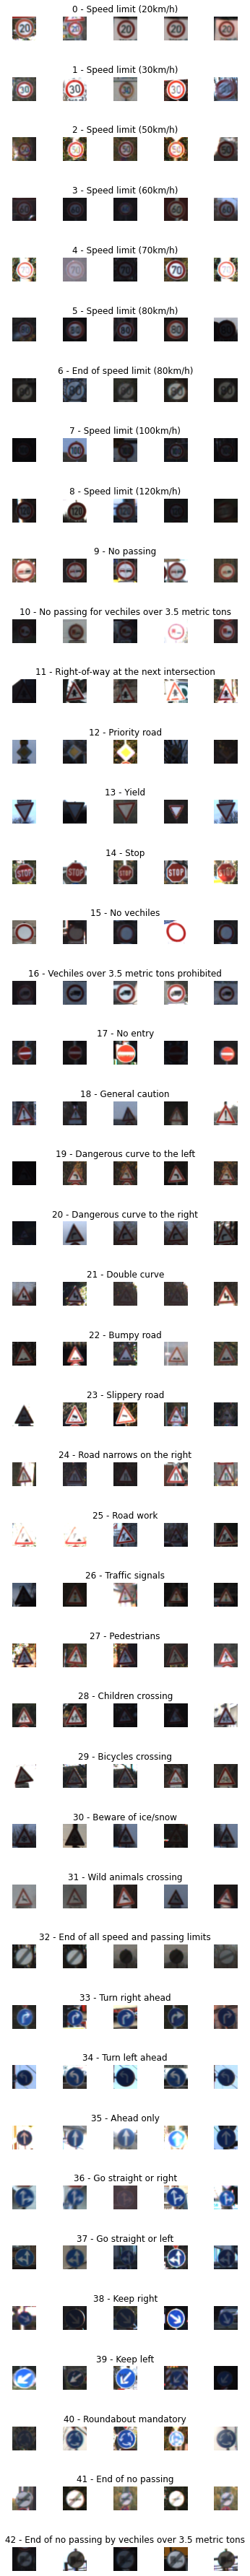

In [11]:
data = pd.read_csv('german-traffic-signs/signnames.csv')


#Plotting the data: We can visualize our data 
sample_number = []
columns = 5 #Random set of 5 images from each of the categories
classes_number = 43 #Since there are 43 traffic signs in our data

fig, axis = plt.subplots(nrows = classes_number, ncols = columns, figsize = (5,50))
fig.tight_layout() #Avoid overlap

#Looping through every column and iterating through every row
for i in range(columns):
  for j, row in data.iterrows():
    x_selected = X_train[y_train == j] #Filtering out the images which don't belong to that class
    axis[j][i].imshow(x_selected[random.randint(0, len(x_selected - 1)), :, :], cmap = plt.get_cmap("gray"))
    axis[j][i].axis("off") #Making images appearing without labeled axis
    if i == 2:
      axis[j][i].set_title(str(j) + " - " + row["SignName"]) #Setting title for each class
      sample_number.append(len(x_selected))

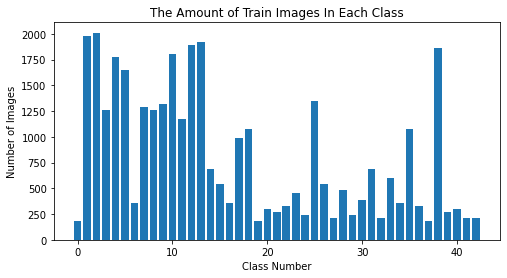

In [12]:
plt.figure(figsize = (8,4))
plt.bar(range(0, classes_number), sample_number) 
plt.title("The Amount of Train Images In Each Class")
plt.xlabel("Class Number")
plt.ylabel("Number of Images")
plt.show()

(32, 32, 3)
36


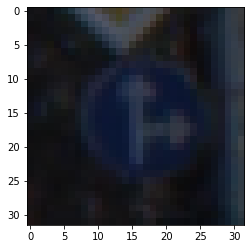

In [13]:
import cv2

plt.imshow(X_train[1000])
print(X_train[1000].shape)
print(y_train[1000])

(32, 32)


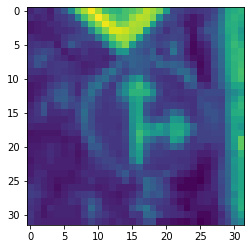

In [14]:
def grayscale(image):
  image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  return(image)

img = grayscale(X_train[1000])
plt.imshow(img)
print(img.shape)

(32, 32)


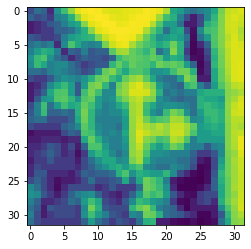

In [15]:
def equalize(image):
  image = cv2.equalizeHist(image)
  return image

img = equalize(img)
plt.imshow(img)
print(img.shape)

In [16]:
def preprocess(image):
  image = grayscale(image)
  image = equalize(image)
  image = image/255
  return image

In [17]:
X_train = np.array(list(map(preprocess, X_train)))
X_valid = np.array(list(map(preprocess, X_valid)))
X_test = np.array(list(map(preprocess, X_test)))

(34799, 32, 32)


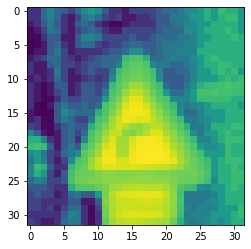

In [18]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
print(X_train.shape)

In [19]:
#Adding depth information to the data

X_train = X_train.reshape(34799, 32, 32, 1)
X_valid = X_valid.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)

In [32]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range = 0.1, height_shift_range = 0.1, zoom_range = 0.2, shear_range = 0.1, rotation_range = 10)

datagen.fit(X_train)

(15, 32, 32, 1)


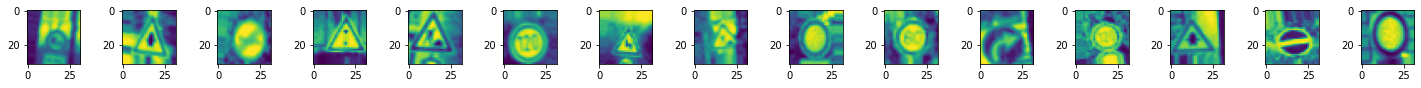

In [36]:
batches = datagen.flow(X_train, y_train, batch_size = 15)
X_batch, y_batch = next(batches)

fig, axis = plt.subplots(1, 15, figsize = (20,5))
fig.tight_layout()

for i in range(15):
  axis[i].imshow(X_batch[i].reshape(32,32))

print(X_batch.shape)

In [21]:
y_train = to_categorical(y_train, 43)
y_valid = to_categorical(y_valid, 43)
y_test = to_categorical(y_test, 43)

In [22]:
def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5,5), input_shape = (32, 32, 1), activation = 'relu'))
  model.add(Conv2D(60, (5,5), activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))

  model.add(Conv2D(30, (3,3), activation = 'relu'))
  model.add(Conv2D(30, (3,3), activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(500, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(43, activation = 'softmax'))
  model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return model

In [23]:
model = modified_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 30)          0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [40]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50), steps_per_epoch=2000, epochs=10, validation_data=(X_valid, y_valid), shuffle = 1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
2000/2000 [==============================] - 21s 10ms/step - loss: 0.9375 - accuracy: 0.7259 - val_loss: 0.1071 - val_accuracy: 0.9732


Text(0.5, 0, 'Epoch')

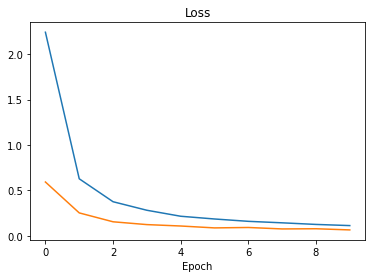

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

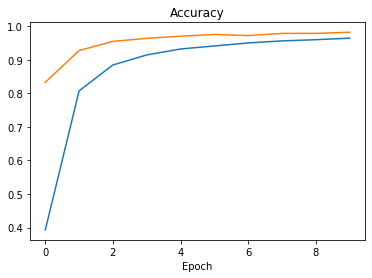

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('Epoch')

In [27]:
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test score: ', score[0])
print('Test accuracy: ', score[1])

Test score:  0.1329541653394699
Test accuracy:  0.9617577195167542


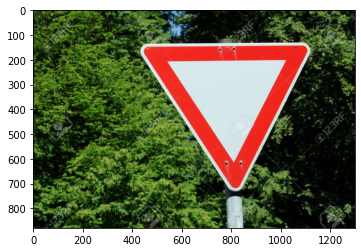

In [62]:
import requests 
from PIL import Image 
url = 'https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg' 
response = requests.get(url, stream=True) 
img = Image.open(response.raw) 
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


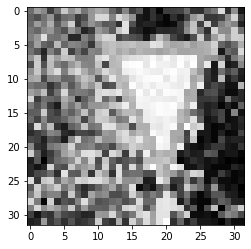

In [63]:
img = np.asarray(img) 
img = cv2.resize(img, (32, 32))
img = preprocess(img) 

plt.imshow(img, cmap = plt.get_cmap('gray'))  
print(img.shape) 

In [64]:
img = img.reshape(1, 32, 32, 1) 

In [65]:
prediction = np.argmax(model.predict(img), axis=-1)
print("Predicted sign: ", str(prediction))

Predicted sign:  [13]
